# Chapter 8: Recommenders for WBSFLIX

This notebook defines various recommenders for the WBSFLIX scenario based on the [MovieLens](http://movielens.org) database:

- popularity-based recommendations
- item-based recommendations
- user-based recommendations

## Modules

In [1]:
import pandas as pd
import sys

sys.path.append('../src/')
from recommenders import *

## Data

In [2]:
movies_df = pd.read_csv('../data/ml-latest-small/movies.csv', index_col='movieId')
movies_df.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings_df = pd.read_csv('../data/ml-latest-small/ratings.csv')
ratings_df.timestamp = pd.to_datetime(ratings_df.timestamp, unit='s')
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51
...,...,...,...,...
100831,610,166534,4.0,2017-05-03 21:53:22
100832,610,168248,5.0,2017-05-03 22:21:31
100833,610,168250,5.0,2017-05-08 19:50:47
100834,610,168252,5.0,2017-05-03 21:19:12


In [4]:
(
  ratings_df
  .head()
  .join(movies_df.title, on='movieId')
)

,userId,movieId,rating,timestamp,title
0,1,1,4.0,2000-07-30 18:45:03,Toy Story (1995)
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men (1995)
2,1,6,4.0,2000-07-30 18:37:04,Heat (1995)
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en) (1995)
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The (1995)"


## Popularity-based recommender

In [5]:
pop_recommendations.df = (ratings_df
  .groupby('movieId')
  .agg(
    rating_mean = ('rating', 'mean'),
    rating_count = ('rating', 'count')
  )
  .sort_values(('rating_count'))
  .reset_index()
  .assign(count_quantile=lambda x: x.index/x.index.max())
  .set_index('movieId')
  .assign(score=lambda x: x.rating_mean**2 * x.rating_count)
  .sort_values('score', ascending=False)
)


### Sebastian's approach

In [7]:
pop_recommendations.df = (ratings_df
  .groupby('movieId')
  .agg(
    rating_mean = ('rating', 'mean'),
    rating_count = ('rating', 'count')
  )
  .sort_values(('rating_count'))
  .reset_index()
  .assign(count_quantile=lambda x: x.index/x.index.max())
  .set_index('movieId')
  .assign(
    score=lambda x:
      (x.rating_count/(x.rating_count + x.rating_count.quantile(0.9)) * x.rating_mean)
      + (x.rating_count.quantile(0.9)/(x.rating_count + x.rating_count.quantile(0.9)) * x.rating_mean.mean())
  )
  .sort_values('score', ascending=False)
)


In [10]:
pop_recommendations(10, 1).join(movies_df.title)


,rating_mean,rating_count,count_quantile,score,title
movieId,,,,,
318,4.429022,317,0.999897,4.337460,"Shawshank Redemption, The (1994)"
858,4.289062,192,0.997840,4.162494,"Godfather, The (1972)"
2959,4.272936,218,0.998972,4.161576,Fight Club (1999)
260,4.231076,251,0.999486,4.137000,Star Wars: Episode IV - A New Hope (1977)
50,4.237745,204,0.998663,4.123749,"Usual Suspects, The (1995)"
296,4.197068,307,0.999794,4.121515,Pulp Fiction (1994)
527,4.225000,220,0.999074,4.119782,Schindler's List (1993)
2571,4.192446,278,0.999589,4.110118,"Matrix, The (1999)"
1196,4.215640,211,0.998766,4.107505,Star Wars: Episode V - The Empire Strikes Back...


## Item-based recommender

In [7]:
user_item_matrix = (
  pd.pivot_table(
    data=ratings_df,
    values='rating',
    index='userId',
    columns='movieId',
    fill_value=0)
  .astype(pd.SparseDtype('float', 0))
)
user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Movie similarity based on user-to-user-cosines

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

item_cosines_matrix = (
  pd.DataFrame(
    cosine_similarity(user_item_matrix.T),
    columns=user_item_matrix.columns,
    index=user_item_matrix.columns)
  .astype(pd.SparseDtype('float', 0))
)

item_cosines_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.410562,1.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.296917,0.282438,1.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.035573,0.106415,0.092406,1.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.308762,0.287795,0.417802,0.188376,1.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
193583,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
193585,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


### Number of users that have rated any pair of movies

In [9]:
# Table showing how many users have rated both of any given pair of books
# The diagonal consequently contains the number of raters for any book
# individually
item_pair_raters = (
  (user_item_matrix.astype('bool').astype('int')) # filter for any rating a user has done
  #.dtypes
  #.astype('int')
  #.astype(pd.SparseDtype('int', 0))         # count each as one
  # calculate the scalar product of any pair of columns (books)
  # which gives the sum of users who have rated both of these books
  .pipe(lambda x: x.T.dot(x)) # nice matrix notation for that
  .astype(pd.SparseDtype('int', 0))
)

In [10]:
item_pair_raters

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,215,68,32,2,32,58,32,5,12,69,...,0,0,0,0,0,0,0,0,0,0
2,68,110,26,3,22,36,18,6,3,56,...,0,0,0,0,0,0,0,0,0,0
3,32,26,52,1,19,25,19,4,9,23,...,0,0,0,0,0,0,0,0,0,0
4,2,3,1,7,3,2,6,1,0,4,...,0,0,0,0,0,0,0,0,0,0
5,32,22,19,3,49,24,23,4,9,20,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
193583,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
193585,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


### Precompute an attenuated score which suppresses scores based on less than 10 raters

But still keep them for cases where there are less than the requested number of recommendations.

Rationale: better bad recommendations than none.

Benefit: Even faster to compute because more is precomputed.


In [11]:
from scipy.special import expit

def sigmoid(x, x0, w):
  """
  Sigmoid using the logistic function centered at `x0` and with (approximate)
  transition width `w`

  sigmoid(x0-2*w, x0, w) ≈ 0.000006
  sigmoid(x0-  w, x0, w) ≈ 0.0025
  sigmoid(x0    , x0, w) = 0.5
  sigmoid(x0+  w, x0, w) ≈ 0.9975
  sigmoid(x0+2*w, x0, w) ≈ 0.999994

  The function theoretically never reaches exactly zero or one, however
  numerically (on Colab):

  sigmoid(   6.122800095, 0, 1) == 1
  sigmoid(-118.29712    , 0, 1) == 0
  """
  return expit(6*(x-x0)/w)

def attenuate(values, criterion, threshold=10, margin=6):
    return values * (criterion.apply(lambda x: sigmoid(x, threshold, margin)))

In [12]:
item_recommendations.df = (
  attenuate(item_cosines_matrix, item_pair_raters, 10, 3)
  .rename_axis('refMovieId')
  .melt(ignore_index=False, value_name='score')
  .sort_values(['refMovieId', 'score'], ascending=[True, False])
  .groupby('refMovieId')
  .head(100)
  .join(item_pair_raters.stack().rename('raters'), on=['refMovieId', 'movieId'])
)
item_recommendations.df

,movieId,score,raters
refMovieId,,,
1,1,1.000000e+00,215
1,3114,5.726013e-01,81
1,480,5.656368e-01,132
1,780,5.642617e-01,122
1,260,5.573882e-01,134
...,...,...,...
193609,8783,1.799563e-09,1
193609,6537,1.791886e-09,1
193609,106782,1.787036e-09,1


In [13]:
item_recommendations(1732, 10).join(movies_df.title)

,score,raters,title
movieId,,,
1732,1.000000,106,"Big Lebowski, The (1998)"
1089,0.603944,72,Reservoir Dogs (1992)
1206,0.578395,65,"Clockwork Orange, A (1971)"
4011,0.567300,58,Snatch (2000)
1682,0.560140,67,"Truman Show, The (1998)"
1884,0.556866,37,Fear and Loathing in Las Vegas (1998)
2997,0.553965,60,Being John Malkovich (1999)
1222,0.548967,55,Full Metal Jacket (1987)
7438,0.545875,59,Kill Bill: Vol. 2 (2004)


## User-based recommender

Here, we use the [surprise](https://surprise.readthedocs.io/en/stable/index.html) library
which comes with slightly different data-set infrastructure.

### Load data

In [14]:
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df.iloc[:, 0:3], reader)

trainset, testset = train_test_split(data, test_size=0.2)

### Optimize meta-parameters

In [15]:
from surprise import KNNBasic, KNNWithMeans, accuracy, KNNWithZScore, SlopeOne
from surprise import SVD
from surprise.model_selection import GridSearchCV

# param_grid = {
#   "n_epochs": [5, 10, 20],
#   "lr_all": [0.002, 0.005],
#   "reg_all": [0.2, 0.4, 0.6],
# }

#gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae", "fcp"], cv=3)

param_grid = {
  "k": [
    #10, 20,
    40,
    #60, 80
  ],
  "sim_options": {
    "name": [
      #"msd",
      #"cosine",
      "pearson"],
    "user_based": [True],
  },
}

gs = GridSearchCV(KNNWithZScore, param_grid, measures=["rmse", "mae", "fcp"], cv=3, n_jobs=-1, joblib_verbose=5)

gs.fit(data)

#knn = KNNWithZScore(sim_options=sim_options)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished


In [16]:
gs.best_params

{'rmse': {'k': 40, 'sim_options': {'name': 'pearson', 'user_based': True}},
 'mae': {'k': 40, 'sim_options': {'name': 'pearson', 'user_based': True}},
 'fcp': {'k': 40, 'sim_options': {'name': 'pearson', 'user_based': True}}}

### Evaluate performance

In [17]:
algo = gs.best_estimator['fcp']
algo.fit(trainset);

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [18]:
predictions = algo.test(testset)
predictions_df = pd.DataFrame(predictions, columns=["userId", "movieId", "actual_user_rating", "estimated_user_rating", "details"])
predictions_df

,userId,movieId,actual_user_rating,estimated_user_rating,details
0,586,96861,5.0,4.916771,"{'actual_k': 2, 'was_impossible': False}"
1,428,5128,2.5,2.048711,"{'actual_k': 4, 'was_impossible': False}"
2,474,2906,1.0,2.637425,"{'actual_k': 4, 'was_impossible': False}"
3,45,4718,5.0,3.150841,"{'actual_k': 30, 'was_impossible': False}"
4,555,2517,4.0,3.109487,"{'actual_k': 8, 'was_impossible': False}"
...,...,...,...,...,...
20163,474,539,4.5,3.333381,"{'actual_k': 40, 'was_impossible': False}"
20164,298,112370,2.5,1.106790,"{'actual_k': 3, 'was_impossible': False}"
20165,474,6660,3.5,3.500490,"{'was_impossible': True, 'reason': 'User and/o..."
20166,484,2010,3.0,4.201600,"{'actual_k': 9, 'was_impossible': False}"


In [19]:
accuracy.mae(predictions), accuracy.rmse(predictions), accuracy.fcp(predictions);

MAE:  0.6725
RMSE: 0.8868
FCP:  0.6577


#### Distribution plot of estimated vs. actual ratings on test-set

/home/til/local/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/til/local/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


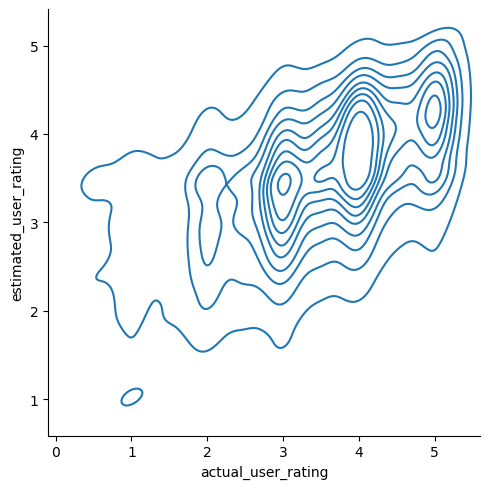

In [20]:
import seaborn as sns
sns.displot(data=predictions_df, x="actual_user_rating", y="estimated_user_rating", kind="kde")

### Preparation of recommender

In [21]:
full_train = data.build_full_trainset()
algo.fit(full_train);

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [22]:
user_recommendations.df = (
    pd.DataFrame(algo.test(full_train.build_anti_testset()))
    [['uid', 'iid', 'est']]
    .sort_values(['uid', 'est'], ascending=[True, False])
    .groupby('uid')
    .head(100)
    .set_index('uid')
)
user_recommendations.df

,iid,est
uid,,
1,318,5.000000
1,48516,5.000000
1,77455,5.000000
1,720,5.000000
1,5181,5.000000
...,...,...
610,130978,4.925397
610,131237,4.925397
610,134095,4.925397


In [23]:
(
  movies_df[lambda x: x.title.str.startswith('Big Lebowski')]
  .join(ratings_df.set_index('movieId'))
  [lambda x: x.rating == 5]
  .sample(1).userId
)

movieId
1732    356
Name: userId, dtype: int64

In [29]:
user_recommendations(182, 10).join(movies_df.title)

,estimated_rating,title
movieId,,
86237,5.0,Connections (1978)
50610,5.0,Beer League (2006)
26169,5.0,Branded to Kill (Koroshi no rakuin) (1967)
3056,5.0,Oxygen (1999)
8477,5.0,"Jetée, La (1962)"
117531,5.0,Watermark (2014)
5328,5.0,Rain (2001)
3379,5.0,On the Beach (1959)
3653,5.0,"Endless Summer, The (1966)"


## Pickle the recommenders

In [9]:
recommenders = [
    pop_recommendations,
    item_recommendations,
    user_recommendations,
]

# collect all the data from the recommenders
recommender_data = {
    r.__name__: r.__dict__ for r in recommenders
}
# save the data to a pickle file
import lz4.frame
with lz4.frame.open('../data/recommenders.pickle.lz4', 'wb') as f:
    import pickle
    pickle.dump(recommender_data, f)